In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
%matplotlib inline

In [2]:
from Gaussian import GAUSSIAN
#from SVN import SVN
#from LaplaceSVN import LaplaceSVN
from DoubleBanana import DOUBLEBANANA
from NonLinRegresssion import NONLINREGRESSION

In [43]:

class SVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 5
        self.nIterations = 1
        self.stepsize = 1
        self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]
        
    def apply(self):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        

        for iter_ in range(self.nIterations):
            F = self.model.getForwardModel(self.particles)
            J = self.model.getJacobianForwardModel(self.particles)

        
            gmlpt  = self.model.getGradientMinusLogPosterior(self.particles, F, J)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(self.particles, J)
            

            M = np.mean(Hmlpt, 2)

            
            for i_ in range(self.nParticles):

                #difference of particle to all other particles
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles

                #adjusts for mean curvature
                Msd   = np.matmul(M, sign_diff)
                
                #caluclates kernel x w.r.t. to all other x'
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                
                #calculates gradient with analytial chain rule
                gkern = Msd * kern

                #averahe gradJ, from SVGD 
                mgJ = np.mean(- gmlpt * kern + gkern , 1)

                #calculates hessian 
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles

                #solves decoupled systems of linear equations
                Q[:,i_] = np.linalg.solve(HJ, mgJ)

                #maximum shift
                maxshift[i_] = np.linalg.norm(Q[:,i_], np.inf)


            self.particles += self.stepsize * Q
            maxmaxshift = np.max(maxshift)
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        self.particles = np.random.normal( scale = 1, size = (self.DoF, self.nParticles) )

In [31]:
model = GAUSSIAN()

In [44]:
svn = SVN(model)


In [45]:
svn.apply()


(2,)
[-2.36833328 -0.45859501]
(2,)
[-1.43208371 -0.4588504 ]
(2,)
[-2.60930265 -0.41175058]
(2,)
[-0.07066482 -0.37196599]
(2,)
[-0.75028474  0.04223701]


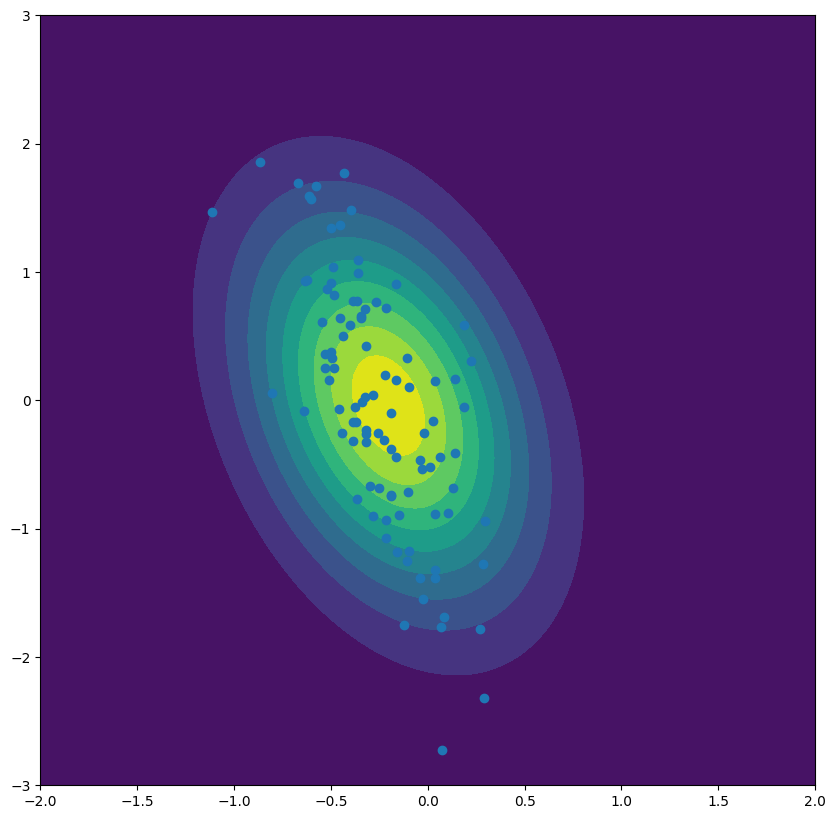

In [7]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [8]:
model = DOUBLEBANANA()

In [9]:
svn = SVN(model)


In [10]:
svn.apply()

(2, 100)
(100,)
(2, 100)
(2, 100)
(2, 2, 100)
(2, 100)
[[ 0.00000000e+00  7.56944404e+02  7.96252685e+02  5.66478681e+02
   1.18040741e+03  1.37368744e+03  5.50296435e+02  5.77613509e+02
   1.97608582e+03  1.17316792e+03  1.32565972e+03  4.23421134e+02
   1.03508237e+03  1.84453440e+03  9.50580853e+02  1.13805579e+03
   1.07458440e+03  5.40090219e+02  8.06260585e+02  1.05796184e+03
   4.10696111e+02  1.18391128e+03  1.94276988e+03  3.24041843e+02
   1.96927226e+03  1.52669329e+03  1.82477015e+03  1.58825470e+03
   2.03617839e+03  1.05420130e+03  2.48440419e+03  1.63203283e+03
   1.22922277e+03  1.58405079e+03  6.62586143e+02  5.66702261e+02
   1.01301237e+03  1.71141472e+03  1.09124392e+03  1.24990636e+03
   1.37471837e+03  9.08347995e+02  9.44422520e+02  6.81882639e+02
   1.90106151e+03  1.50672741e+03  1.07635649e+03  2.28537562e+03
   1.26822684e+03  2.61131043e+03  1.92755624e+02  6.31442972e+02
  -2.81883797e+02  1.53837402e+03  8.44132762e+02  1.47570677e+03
   4.93242909e+02  1.

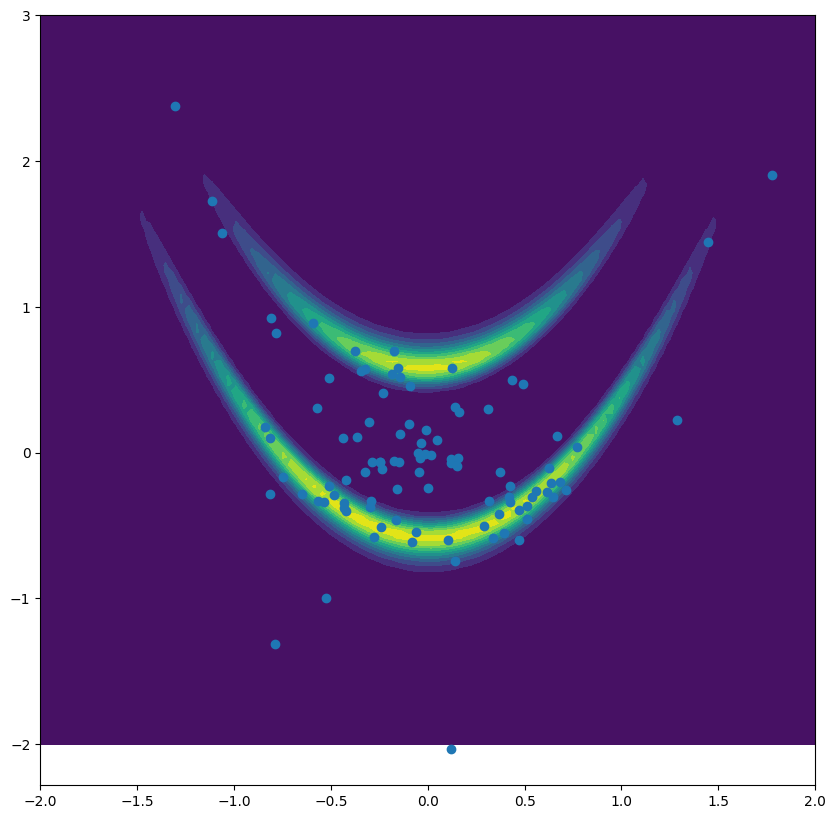

In [11]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [12]:
model = NONLINREGRESSION()

In [13]:
svn = SVN(model)

In [14]:
svn.apply()

(2, 100)
(100,)
(2, 100)
(2, 100)
(2, 2, 100)
(2, 100)
[[   0.          534.75890881  449.89836938  359.85708602  628.65411604
   527.7186845   529.21172434  419.1052001   895.94367321  696.81645567
   783.50557492  581.53129475  740.21204184 1007.25096962  576.45195703
   615.18953728  652.00689235  286.09120193  319.35234831  517.13910619
   205.50307233  758.76476803 1030.25007841  282.16012948  523.5309233
   712.21606278  856.85488961  743.67599429 1001.60191028  591.54425558
   967.71627555  780.22668297  614.1582978   770.08880412  347.01955408
   389.89570769  644.82602806  726.35464343  463.27704022  542.56000532
   616.55340848  458.34243173  745.76237143  471.50527082  968.21266891
   719.15302062  652.33955187  883.52625294  831.78274219 1166.81003882
   288.17422805  501.4071572    69.43208701  784.22071163  502.77271253
   635.29724249  285.9685119   686.11162029  158.07930915  934.29051928
   408.07674665  628.96941572  948.86414905  684.84814146 1092.88628338
   535.860

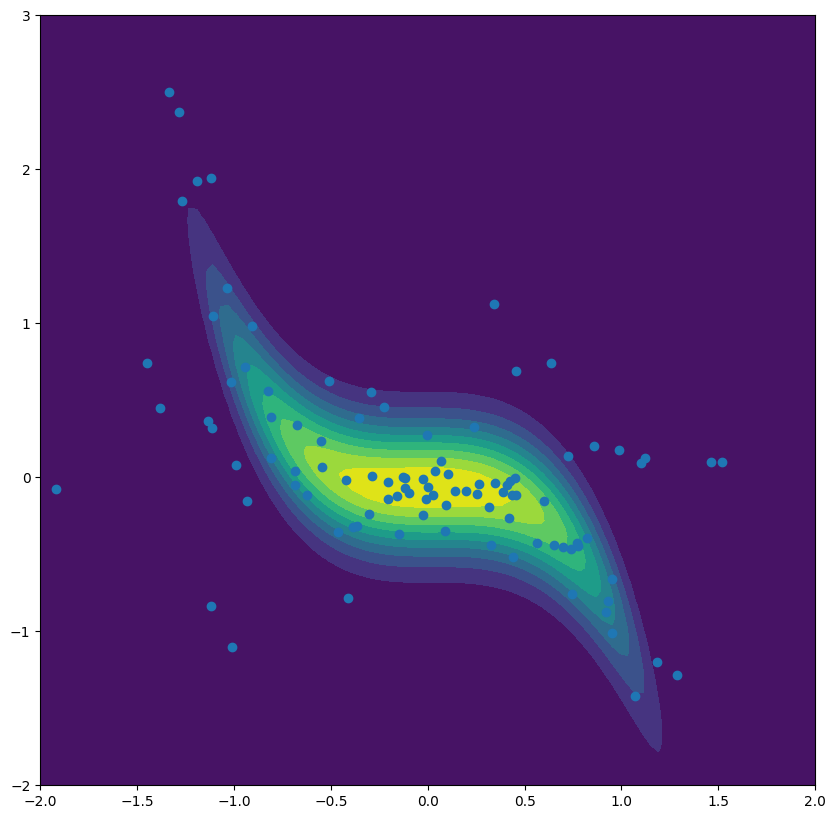

In [15]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])